In [1]:
# Data Science Job Market Analysis for UK (Jupyter Notebook Implementation)

In [2]:
!pip install selenium webdriver-manager requests pandas matplotlib seaborn plotly

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# %% Cell 1: Updated imports (add random module)
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from random import randint, random  # Added random here
from datetime import datetime
import re

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# %% Cell 2: LinkedIn Scraper for Last Month's Jobs
def scrape_linkedin_monthly(search_term="data-scientist", location="United Kingdom", pages=3):
    """
    Scrapes LinkedIn jobs posted in the last 30 days with:
    - Experience extraction (years)
    - Skill detection
    - Company type classification
    - UK city parsing
    """
    base_url = "https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search"
    jobs = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9'
    }
    
    # Skill detection keywords
    skill_keywords = {
        'Python': ['python', 'pandas', 'numpy'],
        'R': ['r ', 'r,', 'tidyverse'],
        'SQL': ['sql', 'postgres', 'mysql'],
        'ML': ['machine learning', 'tensorflow', 'pytorch'],
        'Cloud': ['aws', 'azure', 'gcp']
    }
    
    # Company type indicators
    company_types = {
        'Tech': ['tech', 'software', 'data', 'ai'],
        'Finance': ['bank', 'capital', 'investment'],
        'Consulting': ['consulting', 'mckinsey', 'deloitte'],
        'Corporate': ['plc', 'group', 'holdings']
    }

    for page in range(0, pages):
        params = {
            'keywords': search_term,
            'location': location,
            'start': page * 25,
            'f_TPR': 'r2592000'  # 30 days in seconds
        }
        
        try:
            response = requests.get(base_url, params=params, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            job_cards = soup.find_all('div', class_='base-card')

            for card in job_cards:
                # Basic info extraction
                title = card.find('h3', class_='base-search-card__title').text.strip()
                company = card.find('h4', class_='base-search-card__subtitle').text.strip()
                location = card.find('span', class_='job-search-card__location').text.strip()
                
                # Get posting date (embedded in time tag)
                posted_tag = card.find('time')
                posted_date = posted_tag['datetime'] if posted_tag else None
                
                # UK city extraction
                uk_city = "Not specified"
                for city in ['London', 'Manchester', 'Birmingham', 'Edinburgh']:
                    if city.lower() in location.lower():
                        uk_city = city
                        break
                
                # Job URL for detailed scraping
                job_url = card.find('a', class_='base-card__full-link')['href']
                
                # Initialize detail fields
                skills = []
                experience = 0
                company_type = "Other"
                
                # Detailed scraping (if URL available)
                if job_url:
                    try:
                        job_response = requests.get(job_url, headers=headers)
                        job_soup = BeautifulSoup(job_response.text, 'html.parser')
                        
                        # Extract job description
                        description = job_soup.find('div', class_='description__text').text.lower()
                        
                        # Skill detection
                        detected_skills = [
                            skill for skill, keywords in skill_keywords.items() 
                            if any(kw in description for kw in keywords)
                        ]
                        skills = detected_skills if detected_skills else ["Not specified"]
                        
                        # Experience extraction
                        exp_match = re.search(r'(\d+)\+?\s?years?\s?experience', description, re.IGNORECASE)
                        experience = int(exp_match.group(1)) if exp_match else 0
                        
                        # Company type classification
                        company_desc = job_soup.find('div', class_='about-us__description')
                        if company_desc:
                            desc_text = company_desc.text.lower()
                            for ctype, keywords in company_types.items():
                                if any(kw in desc_text for kw in keywords):
                                    company_type = ctype
                                    break
                        
                        sleep(randint(2, 4))  # Respectful delay
                        
                    except Exception as e:
                        print(f"Error scraping details: {e}")
                
                jobs.append({
                    'title': title,
                    'company': company,
                    'location': location,
                    'uk_city': uk_city,
                    'posted_date': posted_date,
                    'skills': ', '.join(skills),
                    'experience_years': experience,
                    'company_type': company_type,
                    'url': job_url
                })
            
            sleep(randint(3, 6))  # Delay between pages
            
        except Exception as e:
            print(f"Error on page {page}: {e}")
    
    return pd.DataFrame(jobs)

def extract_uk_city(location_str):
    """Extracts UK city from location string"""
    uk_cities = ['London', 'Manchester', 'Birmingham', 'Leeds', 
                'Glasgow', 'Bristol', 'Edinburgh', 'Cardiff']
    for city in uk_cities:
        if city.lower() in location_str.lower():
            return city
    return "Other"

In [5]:
# %% Cell 3: Collect and Analyze Monthly LinkedIn Jobs
# Define search terms - now including multiple roles
search_terms = [
    "data-scientist",
    "data-analyst",
    "machine-learning-engineer",
    "business-analyst"
]

# Initialize empty DataFrame
all_jobs = pd.DataFrame()

# Scrape for each search term
for term in search_terms:
    print(f"Scraping jobs for: {term.replace('-', ' ').title()}")
    
    try:
        term_jobs = scrape_linkedin_monthly(
            search_term=term,
            location="United Kingdom",
            pages=2  # 2 pages = ~50 jobs per term
        )
        
        # Add search term as column
        term_jobs['search_term'] = term.replace('-', ' ').title()
        
        # Append to master DataFrame
        all_jobs = pd.concat([all_jobs, term_jobs], ignore_index=True)
        
        print(f"→ Collected {len(term_jobs)} jobs")
        sleep(randint(10, 15))  # Important delay between searches
    
    except Exception as e:
        print(f"Error scraping {term}: {e}")
        continue



Scraping jobs for: Data Scientist
→ Collected 20 jobs
Scraping jobs for: Data Analyst
→ Collected 20 jobs
Scraping jobs for: Machine Learning Engineer
→ Collected 20 jobs
Scraping jobs for: Business Analyst
→ Collected 20 jobs


In [6]:
# Data Cleaning
print("\nCleaning data...")

# Convert posted_date to datetime
all_jobs['posted_date'] = pd.to_datetime(all_jobs['posted_date'])

# Extract month/year for analysis
all_jobs['post_month'] = all_jobs['posted_date'].dt.to_period('M')

# Clean experience (handle missing values)
all_jobs['experience_years'] = all_jobs['experience_years'].fillna(0).astype(int)

# Display results
print(f"\nTotal jobs collected: {len(all_jobs)}")
print("Sample data:")
pd.set_option('display.max_columns', None)
display(all_jobs.head(20))

# Basic Analysis
print("\nQuick Analysis:")
print("1. Jobs by Role:")
print(all_jobs['search_term'].value_counts())

print("\n2. Top Locations:")
print(all_jobs['uk_city'].value_counts().head(5))

print("\n3. Average Experience Required:")
print(round(all_jobs.groupby('search_term')['experience_years'].mean(), 1))


Cleaning data...

Total jobs collected: 80
Sample data:


,title,company,location,uk_city,posted_date,skills,experience_years,company_type,url,search_term,post_month
0,Python Developer,TieTalent,"High Wycombe, England, United Kingdom",Not specified,2025-05-16,"Python, R, SQL",0,Other,https://uk.linkedin.com/jobs/view/python-devel...,Data Scientist,2025-05
1,"Data Scientist, Product Analytics",Meta,"London, England, United Kingdom",London,2025-05-06,"Python, R, SQL",4,Other,https://uk.linkedin.com/jobs/view/data-scienti...,Data Scientist,2025-05
2,Head of Data Science,TieTalent,"Reading, England, United Kingdom",Not specified,2025-05-09,"Python, R, ML, Cloud",0,Other,https://uk.linkedin.com/jobs/view/head-of-data...,Data Scientist,2025-05
3,Growth Data Scientist/ Analyst,Crypto.com,"London, England, United Kingdom",London,2025-05-05,"Python, R, SQL",0,Other,https://uk.linkedin.com/jobs/view/growth-data-...,Data Scientist,2025-05
4,"Data Scientist, Product Analytics",Meta,"London, England, United Kingdom",London,2025-05-06,"Python, R, SQL",0,Other,https://uk.linkedin.com/jobs/view/data-scienti...,Data Scientist,2025-05
5,"Data Scientist, Internship, United Kingdom - B...",TieTalent,"London, England, United Kingdom",London,2025-05-10,"Python, R, ML, Cloud",0,Other,https://uk.linkedin.com/jobs/view/data-scienti...,Data Scientist,2025-05
6,Data Scientist,Snap Inc.,"London, England, United Kingdom",London,2025-05-12,"Python, R, SQL, ML, Cloud",0,Other,https://uk.linkedin.com/jobs/view/data-scienti...,Data Scientist,2025-05
7,Research Engineer - Machine Learning,Sony Interactive Entertainment,"London, England, United Kingdom",London,2025-05-15,"Python, R, ML",0,Other,https://uk.linkedin.com/jobs/view/research-eng...,Data Scientist,2025-05
8,Data Scientists,HM Land Registry,"London, England, United Kingdom",London,2025-05-22,"Python, R, ML",0,Other,https://uk.linkedin.com/jobs/view/data-scienti...,Data Scientist,2025-05
9,"Data Scientist, Internship, United Kingdom - B...",Boston Consulting Group (BCG),"London, England, United Kingdom",London,2025-05-13,"Python, R, ML, Cloud",0,Other,https://uk.linkedin.com/jobs/view/data-scienti...,Data Scientist,2025-05



Quick Analysis:
1. Jobs by Role:
search_term
Data Scientist               20
Data Analyst                 20
Machine Learning Engineer    20
Business Analyst             20
Name: count, dtype: int64

2. Top Locations:
uk_city
London           57
Not specified    21
Manchester        1
Birmingham        1
Name: count, dtype: int64

3. Average Experience Required:
search_term
Business Analyst             0.0
Data Analyst                 0.0
Data Scientist               0.2
Machine Learning Engineer    0.2
Name: experience_years, dtype: float64


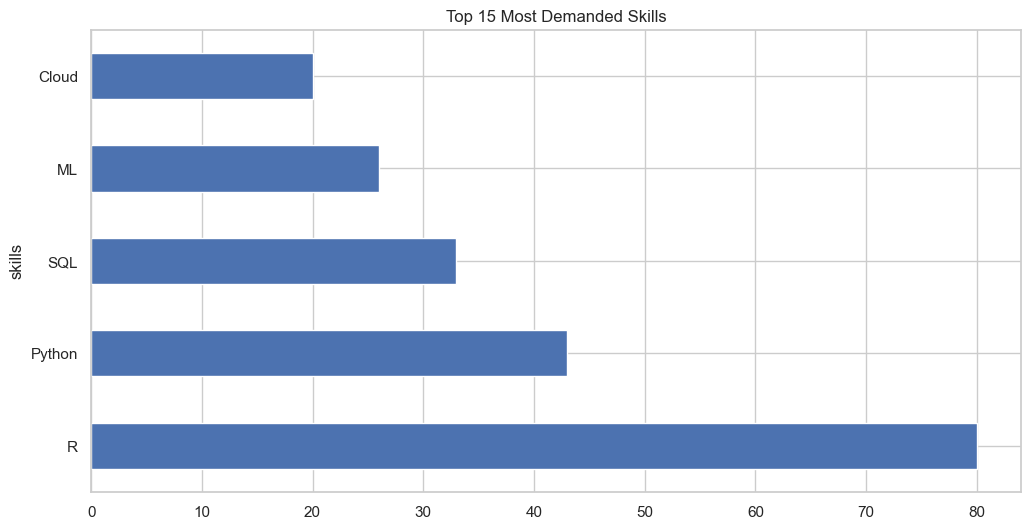

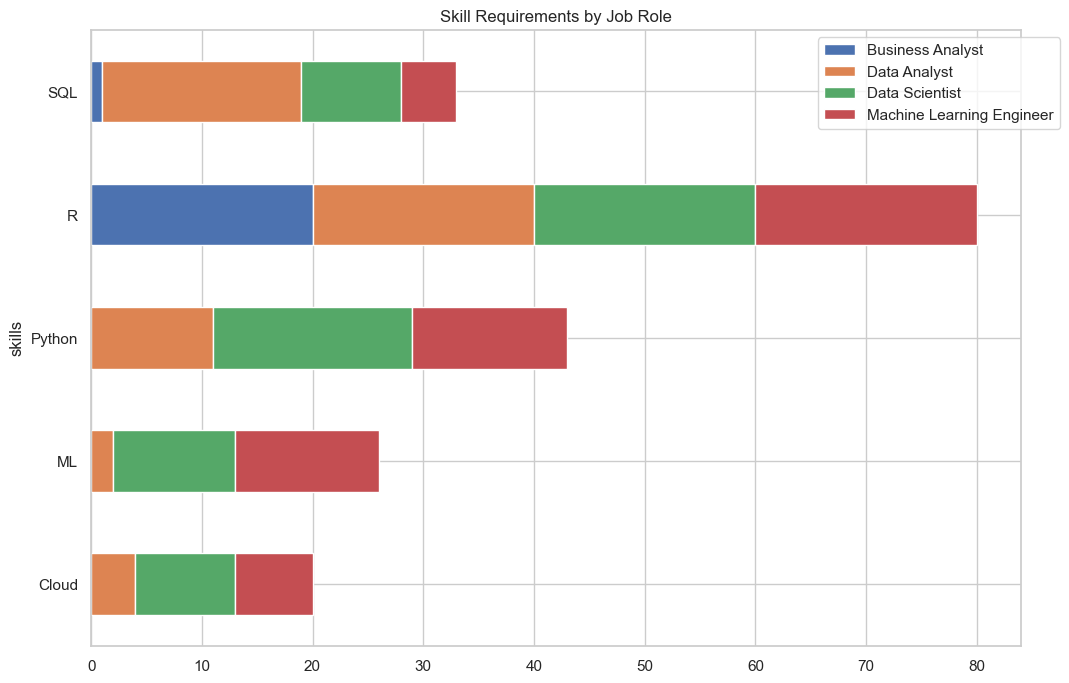

In [7]:
# %% Cell 4: Skills Frequency Analysis
# Explode skills into separate rows
skills_exploded = all_jobs.assign(skills=all_jobs['skills'].str.split(', ')).explode('skills')

# Top skills overall
plt.figure(figsize=(12,6))
skills_exploded['skills'].value_counts().head(15).plot(kind='barh', title='Top 15 Most Demanded Skills')
plt.show()

# Skills by role
pd.crosstab(skills_exploded['search_term'], skills_exploded['skills']).T.plot(
    kind='barh', stacked=True, figsize=(12,8), 
    title='Skill Requirements by Job Role'
)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

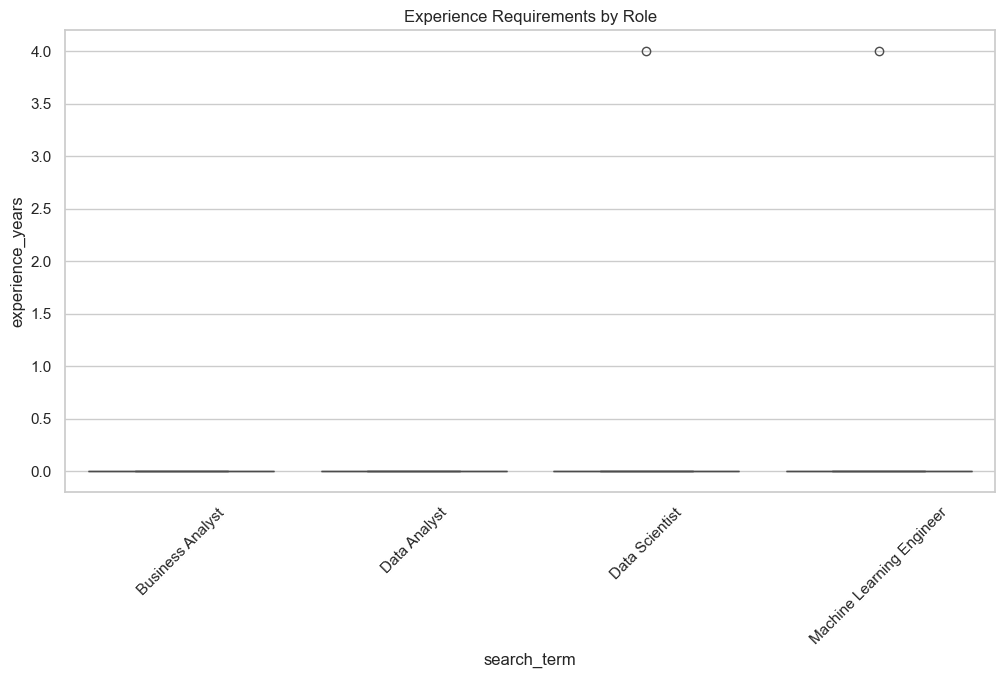

In [8]:
# %% Cell 5: Experience Distribution
plt.figure(figsize=(12,6))
sns.boxplot(
    data=all_jobs, 
    x='search_term', 
    y='experience_years',
    order=['Business Analyst', 'Data Analyst', 'Data Scientist', 'Machine Learning Engineer']
)
plt.title('Experience Requirements by Role')
plt.xticks(rotation=45)
plt.show()

<Figure size 1400x600 with 0 Axes>

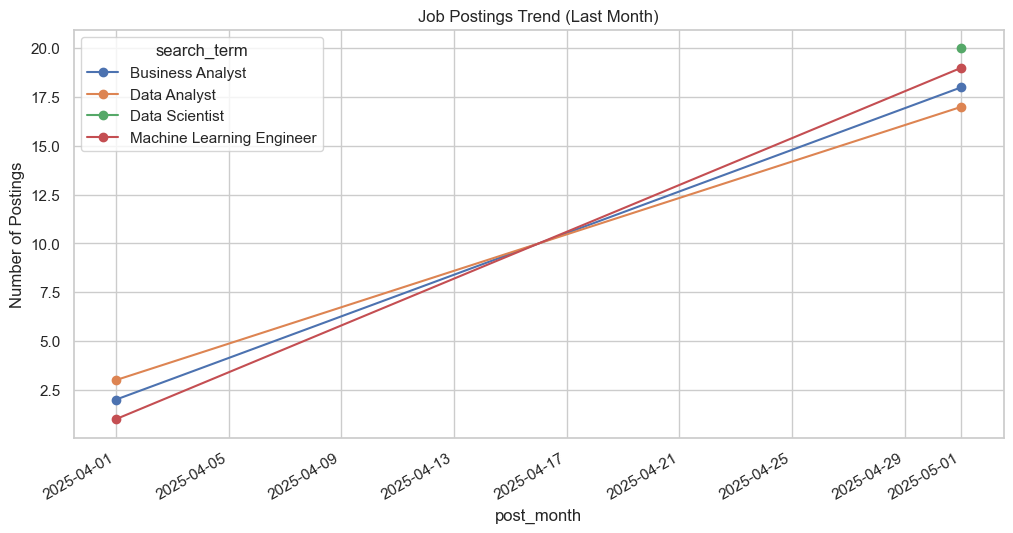

In [10]:
# %% Cell 6: Posting Trends Over Time
# Convert post_month to datetime for plotting
trend_data = all_jobs.copy()
trend_data['post_month'] = trend_data['post_month'].dt.to_timestamp()

plt.figure(figsize=(14,6))
trend_data.groupby(['post_month', 'search_term']).size().unstack().plot(
    marker='o',
    title='Job Postings Trend (Last Month)'
)
plt.ylabel('Number of Postings')
plt.grid(True)
plt.show()

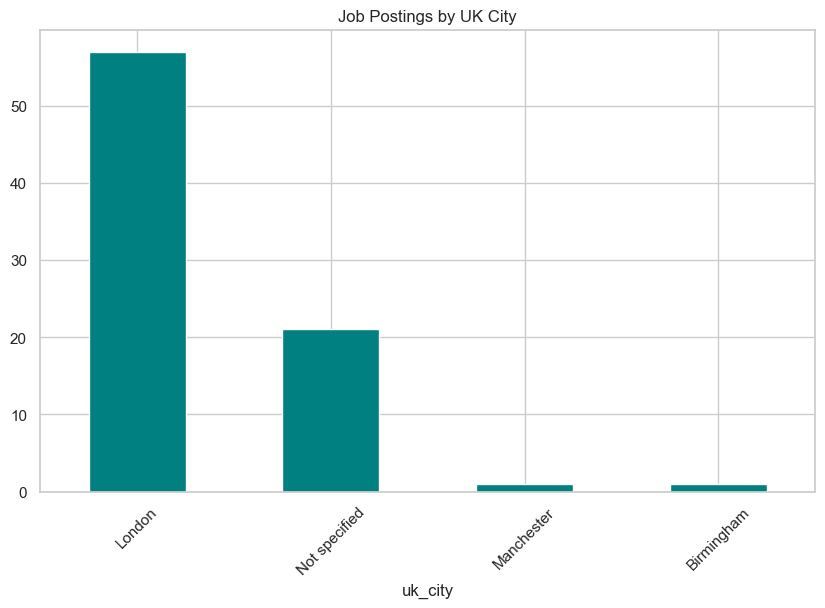

In [11]:
# %% Cell 7: Location Heatmap
if 'uk_city' in all_jobs.columns:
    location_counts = all_jobs['uk_city'].value_counts()
    
    # Simple UK map visualization (requires geopandas for more advanced)
    plt.figure(figsize=(10,6))
    location_counts.plot(kind='bar', color='teal')
    plt.title('Job Postings by UK City')
    plt.xticks(rotation=45)
    plt.show()

In [12]:
# %% Export Results
all_jobs.to_csv('linkedin_jobs_analysis.csv', index=False)
print("Results saved to linkedin_jobs_analysis.csv")

Results saved to linkedin_jobs_analysis.csv
